Introduction-

For this assignment, I choose to create a CycleGAN on the Monet painting set hosted on Kaggle. The task is to convert a set of regular images to Monet style

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import layers,optimizers,Sequential
from keras.layers import Conv2D,Input,MaxPooling2D,Conv2DTranspose
import tensorflow as tf
import os
import keras
import shutil
from tqdm import trange

In [2]:
def load_image(image_path):
    img=tf.io.read_file(image_path)
    img=tf.image.decode_jpeg(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    img=tf.image.resize(img,[256,256])
    return img

monet_image_files=tf.data.Dataset.list_files('monet_jpg/*.jpg')
output_image_files=tf.data.Dataset.list_files('photo_jpg/*.jpg')

monet_ds=monet_image_files.map(load_image).shuffle(buffer_size=1000).batch(1).repeat()
output_ds=output_image_files.map(load_image).shuffle(buffer_size=1000).batch(1).repeat()

Given the huge size of the dataset, i have created an iterable object through tensorflow to pull in a batch of images at a time. now let's explore images from both datasets

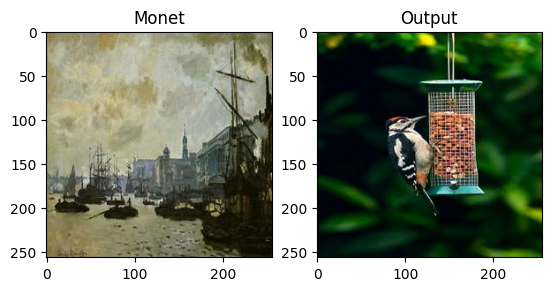

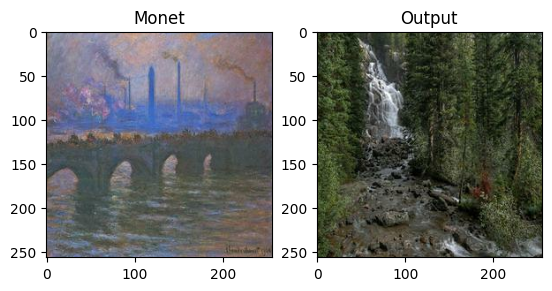

In [16]:
monet_itr=iter(monet_ds)
output_itr=iter(output_ds)
for i in range(2):
    plt.subplot(1,2,1)
    plt.title("Monet")
    plt.imshow(monet_itr.next()[0])
    plt.subplot(1,2,2)
    plt.title("Output")
    plt.imshow(output_itr.next()[0])
    plt.show()

Now let's proceed to model building. Since I'm going to create a GAN for this task, I would first need to set up a Discriminator and a Generator

In [3]:
def create_discriminator(name):
    discriminator=keras.Sequential(
      [
          keras.Input(shape=[256,256,3]),
          layers.Conv2D(64,kernel_size=4,strides=2,padding="same"),
          layers.LeakyReLU(negative_slope=0.15),
          layers.Conv2D(128,kernel_size=4,strides=2,padding="same"),
          layers.LeakyReLU(negative_slope=0.15),
          layers.Conv2D(256,kernel_size=4,strides=2,padding="same"),
          layers.LeakyReLU(negative_slope=0.15),
          layers.Conv2D(1,kernel_size=4,strides=2,padding="same")
      ],
      name=name,
  )
    discriminator.summary()
    return discriminator


In [4]:
def create_generator(name):

  generator=keras.Sequential(
      [
          keras.Input(shape=[256,256,3]),
          # Downsampling
          layers.Conv2D(256,kernel_size=4,strides=2,padding="same"),
          layers.LeakyReLU(negative_slope=0.15),
          layers.Conv2D(128,kernel_size=4,strides=2,padding="same"),
          layers.LeakyReLU(negative_slope=0.15),
          layers.Conv2D(64,kernel_size=4,strides=2,padding="same"),
          layers.LeakyReLU(negative_slope=0.15),
          # Upsampling
          layers.Conv2DTranspose(64,kernel_size=4,strides=2,padding="same"),
          layers.LeakyReLU(negative_slope=0.15),
          layers.Conv2DTranspose(128,kernel_size=4,strides=2,padding="same"),
          layers.LeakyReLU(negative_slope=0.15),
          layers.Conv2DTranspose(256,kernel_size=4,strides=2,padding="same"),
          layers.LeakyReLU(negative_slope=0.15),
          layers.Conv2D(3,kernel_size=5,padding="same",activation="sigmoid"),
      ],
      name=name,
  )
  generator.summary()
  return generator

In [5]:
gen_G=create_generator(name="generator_G")
gen_F=create_generator(name="generator_F")

disc_X=create_discriminator(name="discriminator_X")
disc_Y=create_discriminator(name="discriminator_Y")

Model: "generator_G"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 256)  │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 64)     │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 128)  │       131,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 256)  │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256, 256, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 3)    │        19,203 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,408,643 (5.37 MB)

 Trainable params: 1,408,643 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

Model: "generator_F"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 256)  │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 64)     │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 128)  │       131,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 256, 256, 256)  │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 256, 256, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 3)    │        19,203 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,408,643 (5.37 MB)

 Trainable params: 1,408,643 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator_X"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 1)      │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,977 (2.53 MB)

 Trainable params: 662,977 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator_Y"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 1)      │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,977 (2.53 MB)

 Trainable params: 662,977 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

Now let's set up our loss functions for our GAN model. Note that we would need to define loss for both Discriminator and Generator and for our CycleGAN model. I also choose to use Adam optimizer for this model

In [6]:
def discriminator_loss(real, generated):
    real_loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real),real)
    generated_loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated),generated)
    total_loss=real_loss+generated_loss
    return total_loss*0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated),generated)

def calc_cycle_loss(real_image,cycled_image,lambda_value=10):
    return lambda_value*tf.reduce_mean(tf.abs(real_image-cycled_image))

def identity_loss(real_image,same_image,lambda_value=5):
    return lambda_value*0.5*tf.reduce_mean(tf.abs(real_image-same_image))

generator_g_optimizer=tf.keras.optimizers.Adam()
generator_f_optimizer=tf.keras.optimizers.Adam()

discriminator_x_optimizer=tf.keras.optimizers.Adam()
discriminator_y_optimizer=tf.keras.optimizers.Adam()


Now that I've created our Generator and Discriminator and have defined their loss functions. I can proceed to build our CycleGAN.

In [7]:
class CycleGAN(tf.keras.Model):
    def __init__(self,generator_g,generator_f,discriminator_x,discriminator_y):
        super(CycleGAN,self).__init__()
        self.generator_g=generator_g
        self.generator_f=generator_f
        self.discriminator_x=discriminator_x
        self.discriminator_y=discriminator_y

        self.generator_g_optimizer=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
        self.generator_f_optimizer=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
        self.discriminator_x_optimizer=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
        self.discriminator_y_optimizer=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

        self.generator_loss_fn=generator_loss
        self.discriminator_loss_fn=discriminator_loss
        self.cycle_loss_fn=calc_cycle_loss
        self.identity_loss_fn=identity_loss

    def call(self, inputs):
        real_x, real_y=inputs

        fake_y=self.generator_g(real_x)
        cycled_x=self.generator_f(fake_y)

        fake_x=self.generator_f(real_y)
        cycled_y=self.generator_g(fake_x)

        disc_real_x=self.discriminator_x(real_x)
        disc_fake_x=self.discriminator_x(fake_x)

        disc_real_y=self.discriminator_y(real_y)
        disc_fake_y=self.discriminator_y(fake_y)

        return fake_y,cycled_x,fake_x,cycled_y,disc_real_x,disc_fake_x,disc_real_y,disc_fake_y

    @tf.function
    def train_step(self,batch_data):
        real_x,real_y=batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_y=self.generator_g(real_x)
            cycled_x=self.generator_f(fake_y)

            fake_x=self.generator_f(real_y)
            cycled_y=self.generator_g(fake_x)

            same_x=self.generator_f(real_x)
            same_y=self.generator_g(real_y)

            disc_real_x=self.discriminator_x(real_x)
            disc_fake_x=self.discriminator_x(fake_x)

            disc_real_y=self.discriminator_y(real_y)
            disc_fake_y=self.discriminator_y(fake_y)

            gen_g_loss=self.generator_loss_fn(disc_fake_y)
            gen_f_loss=self.generator_loss_fn(disc_fake_x)

            cycle_loss_x=self.cycle_loss_fn(real_x,cycled_x)
            cycle_loss_y=self.cycle_loss_fn(real_y,cycled_y)

            identity_loss_x=self.identity_loss_fn(real_x,same_x)
            identity_loss_y=self.identity_loss_fn(real_y,same_y)

            total_gen_g_loss=gen_g_loss+cycle_loss_x+identity_loss_y
            total_gen_f_loss=gen_f_loss+cycle_loss_y+identity_loss_x

            disc_x_loss=self.discriminator_loss_fn(disc_real_x,disc_fake_x)
            disc_y_loss=self.discriminator_loss_fn(disc_real_y,disc_fake_y)

        generator_g_gradients=tape.gradient(total_gen_g_loss,self.generator_g.trainable_variables)
        generator_f_gradients=tape.gradient(total_gen_f_loss,self.generator_f.trainable_variables)
        discriminator_x_gradients=tape.gradient(disc_x_loss,self.discriminator_x.trainable_variables)
        discriminator_y_gradients=tape.gradient(disc_y_loss,self.discriminator_y.trainable_variables)

        self.generator_g_optimizer.apply_gradients(zip(generator_g_gradients,self.generator_g.trainable_variables))
        self.generator_f_optimizer.apply_gradients(zip(generator_f_gradients,self.generator_f.trainable_variables))
        self.discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,self.discriminator_x.trainable_variables))
        self.discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,self.discriminator_y.trainable_variables))

        return {
            "gen_g_loss": total_gen_g_loss,
            "gen_f_loss": total_gen_f_loss,
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss
        }

Now let's compile and fit the model on the dataset. Given my limited computation power, I choose to train the model on only a 1000 images

In [8]:
cycle_gan_model=CycleGAN(
    generator_g=gen_G,
    generator_f=gen_F,
    discriminator_x=disc_X,
    discriminator_y=disc_Y
)
cycle_gan_model.compile()
train_dataset = tf.data.Dataset.zip((output_ds, monet_ds))
cycle_gan_model.fit(train_dataset.take(1000), epochs=20)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 263s 240ms/step - disc_x_loss: 0.6742 - disc_y_loss: 0.6631 - gen_f_loss: 2.3952 - gen_g_loss: 2.5319
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 242s 241ms/step - disc_x_loss: 0.6579 - disc_y_loss: 0.6575 - gen_f_loss: 1.9063 - gen_g_loss: 1.9371
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 241s 240ms/step - disc_x_loss: 0.6583 - disc_y_loss: 0.6434 - gen_f_loss: 1.9504 - gen_g_loss: 1.9938
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 241s 240ms/step - disc_x_loss: 0.6525 - disc_y_loss: 0.6418 - gen_f_loss: 1.9068 - gen_g_loss: 1.9545
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 241s 240ms/step - disc_x_loss: 0.4671 - disc_y_loss: 0.6601 - gen_f_loss: 4.7840 - gen_g_loss: 3.0291
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 242s 240ms/step - disc_x_loss: 0.6431 - disc_y_loss: 0.6613 - gen_f_loss: 1.8867 - gen_g_loss: 1.8628
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 241s 240ms/step - disc_x_loss: 0.6362 - disc_y_loss: 0.6670 - gen_f_loss: 2.0230 - gen_g_loss:

Now that the model has been fit, I'll try to plot the output images in monet format

In [9]:
def plot_predictions(model, ds):
    ds_iter = iter(ds)
    for n_sample in range(4):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample, verbose=0)
        f = plt.figure(figsize=(13, 13))
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0])
        plt.axis('off')
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0])
        plt.axis('off')
        plt.show()

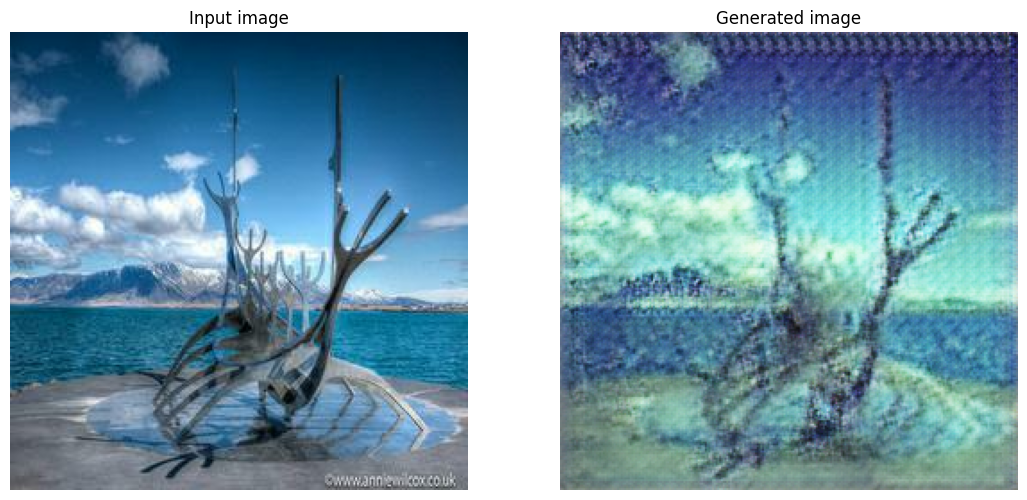

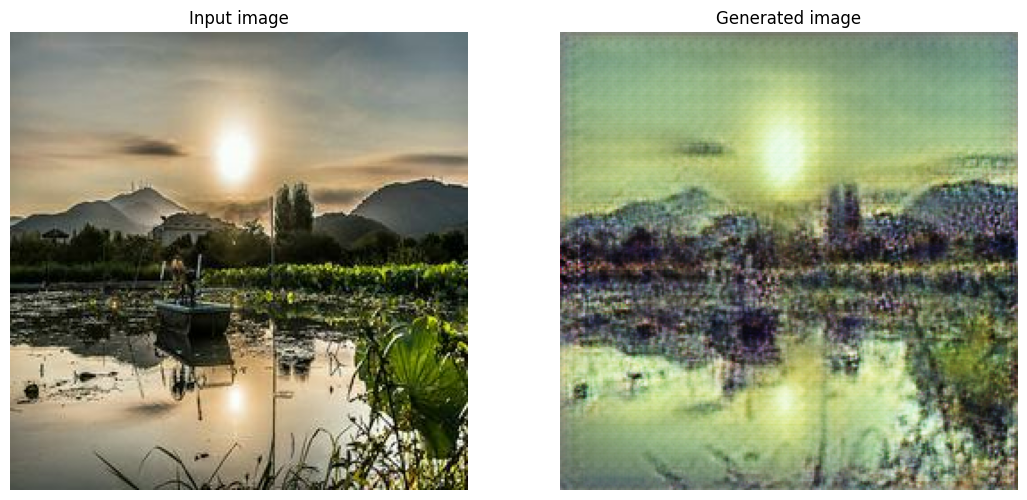

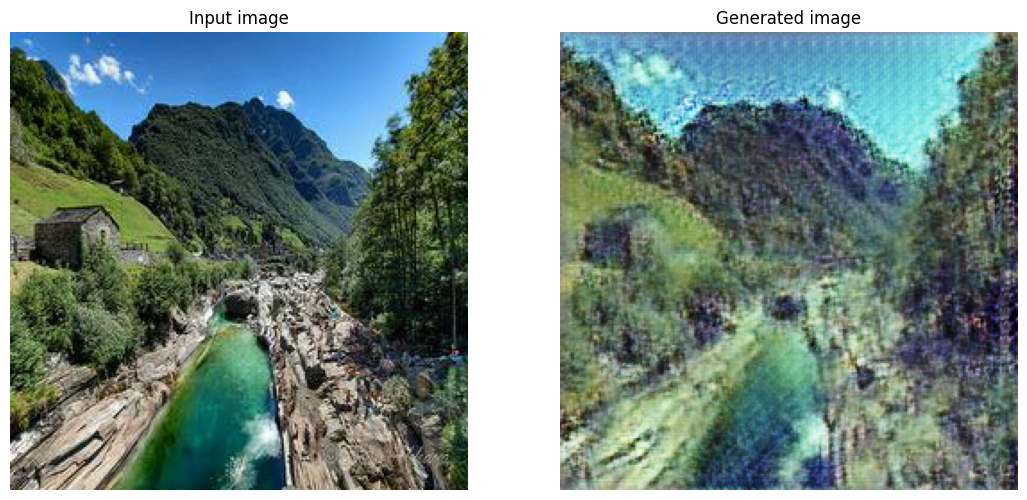

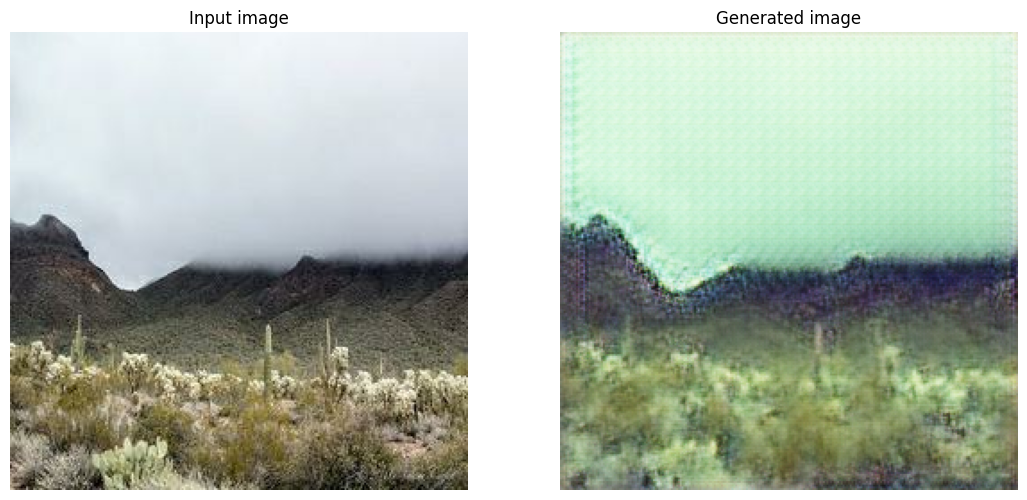

In [10]:
plot_predictions(gen_G,output_ds.shuffle(1000))

While the output images are not a 100% in Monet style, we can see that they do have some of the effects. If the model was trained on more images and for more iterations, the output could've looked more realistic.

In [11]:
cycle_gan_model.save('gan_model.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [17]:
output_dir = 'generated_monet_images'
os.makedirs(output_dir, exist_ok=True)

for image_path in output_image_files:
    image = load_image(image_path)
    image = tf.expand_dims(image, axis=0)

    generated_image = gen_G.predict(image, verbose=0)[0]
    generated_image = tf.image.convert_image_dtype(generated_image, dtype=tf.uint8)
    generated_image = tf.image.encode_jpeg(generated_image)

    original_filename = os.path.basename(image_path.numpy().decode('utf-8'))
    file_path = os.path.join(output_dir, original_filename)
    tf.io.write_file(file_path, generated_image)

print(f"Generated and saved images to '{output_dir}'")

Generated and saved images to 'generated_monet_images'


In [18]:
output_dir = 'generated_monet_images'
zip_filename = 'monet_generated_images.zip'

shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', output_dir)

print(f"Created zip archive: {zip_filename}")

Created zip archive: monet_generated_images.zip
